In [36]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
from torch import nn
import argparse
import torch.nn.functional as F
import utils
import dataset
import os
import matplotlib.pyplot as plt
import torch.optim as optim

In [37]:
import numpy as np

dataPath = 'data/albatross.npy'
data = np.load(dataPath)
print(data.shape)

(32561, 16, 4)


In [38]:
dataPath2 = 'data/albatross_prior_samples.npy'
data2 = np.load(dataPath2)
print(data2.shape)

(32561, 64)


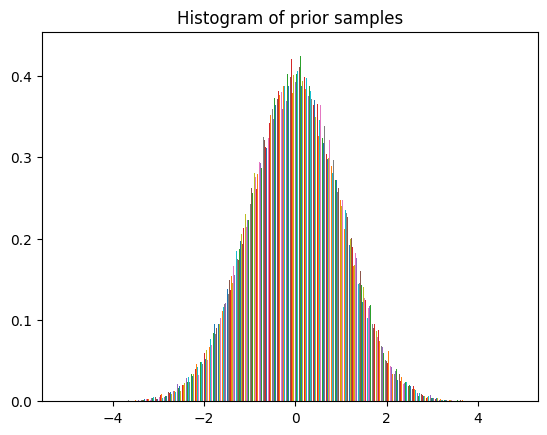

In [39]:
# Make a histogram of the prior sample data
plt.hist(data2, bins=100, density=True)
plt.title('Histogram of prior samples')
plt.show()

In [40]:
moonDataX, moonDataY = dataset.load_dataset('moons')
print(type(moonDataX))
print(moonDataX.shape)
print(type(moonDataY))
print(moonDataY.shape)

<class 'torch.Tensor'>
torch.Size([8000, 2])
<class 'torch.Tensor'>
torch.Size([8000])


In [41]:
# Define the time embedding class to generate sinusoidal embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, numDim : int):
        super().__init__()
        self.numDim = numDim

    def forward(self, time : torch.Tensor):
        '''
        Input:
            time: (batchSize, 1)
        Output:
            embedding: (batchSize, numDim)
        '''
        # Generate the sinusoidal embeddings
        embedding = torch.zeros(time.shape[0], self.numDim)
        for i in range(self.numDim):
            if i % 2 == 0:
                embedding[:, i] = torch.sin(time / 10000 ** (i / self.numDim))
            else:
                embedding[:, i] = torch.cos(time / 10000 ** ((i - 1) / self.numDim))
        return embedding


In [42]:
# Test the time embedding class to generate sinusoidal embeddings
timeEmbedding = TimeEmbedding(10)
timeSteps = torch.arange(0, 100)
print(timeSteps.shape)
embeddings = timeEmbedding(timeSteps)
print(embeddings.shape)
print(embeddings[2, :])

torch.Size([100])
torch.Size([100, 10])
tensor([ 0.9093, -0.4161,  0.3117,  0.9502,  0.0502,  0.9987,  0.0080,  1.0000,
         0.0013,  1.0000])


In [43]:
# Write the Noise Scheduler class that will be used for training the DDPM Model
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Precompute whatever quantities are required for training and sampling
        """
        self.betaSchedule = torch.linspace(beta_start, beta_end, self.num_timesteps)
        self.alpha = 1 - self.betaSchedule
        self.alphaProd = torch.cumprod(self.alpha, 0)
        self.sqrtCumprodAlpha = np.sqrt(self.alphaProd)
        self.sqrtAlpha = np.sqrt(self.alpha)
        self.sqrtOneMinusAlpha = np.sqrt(1 - self.alpha)
        self.sqrtOneMinusAlphaProd = torch.sqrt(1 - self.alphaProd)

    def __len__(self):
        return self.num_timesteps

In [44]:
noiseScheduler = NoiseScheduler(num_timesteps=50, 
                                type="linear", 
                                beta_start=0.0001, 
                                beta_end=0.02)
# print(noiseScheduler.betaSchedule)
print(noiseScheduler.alpha)

tensor([0.9999, 0.9995, 0.9991, 0.9987, 0.9983, 0.9979, 0.9975, 0.9971, 0.9967,
        0.9962, 0.9958, 0.9954, 0.9950, 0.9946, 0.9942, 0.9938, 0.9934, 0.9930,
        0.9926, 0.9922, 0.9918, 0.9914, 0.9910, 0.9906, 0.9902, 0.9897, 0.9893,
        0.9889, 0.9885, 0.9881, 0.9877, 0.9873, 0.9869, 0.9865, 0.9861, 0.9857,
        0.9853, 0.9849, 0.9845, 0.9841, 0.9837, 0.9832, 0.9828, 0.9824, 0.9820,
        0.9816, 0.9812, 0.9808, 0.9804, 0.9800])


In [45]:
class MLPModel(nn.Module):
    def __init__(self, inputDim : int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output


In [46]:
class AdvancedMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        # Keep the rest of the model same, change the activation function to SiLU
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.SiLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

        

In [47]:
class ResidualMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim

        # Input projection layer
        self.input_proj = nn.Linear(inputDim + timeEmbedDim, hiddenDim)

        # Main network with residual blocks
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hiddenDim, hiddenDim),  # Concatenate time embedding
                nn.SiLU(),
                nn.Linear(hiddenDim, hiddenDim)
            )
            for _ in range(4)  # Number of residual blocks
        ])

        # Output projection layer
        self.output_proj = nn.Linear(hiddenDim, inputDim)

    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x: Input tensor of shape (batch_size, inputDim)
            time: Time tensor of shape (batch_size, 1)
        Returns:
            Output tensor of shape (batch_size, inputDim)
        """
        # Time embedding
        # time_embed = self.time_embed(time)  # (batch_size, timeEmbedDim)

        # Input projection
        h = self.input_proj(x)  # (batch_size, hiddenDim)

        # Residual blocks
        for block in self.residual_blocks:
            # Concatenate time embedding
            # h_input = torch.cat([h, time_embed], dim=-1)  # (batch_size, hiddenDim + timeEmbedDim)
            # Residual connection
            h = h + block(h)  # (batch_size, hiddenDim)

        # Output projection
        out = self.output_proj(h)  # (batch_size, inputDim)

        return out

In [48]:
class DDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200):
        """
        Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
        We have separate learnable modules for `time_embed` and `model`. `time_embed` can be learned or a fixed function as well

        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        # self.model = MLPModel(n_dim, self.time_embed_dim)
        # self.model = AdvancedMLPModel(n_dim, self.time_embed_dim)
        self.model = ResidualMLPModel(n_dim, self.time_embed_dim)

    def forward(self, x, t):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Concatenate the input data with the time embeddings
        input = torch.cat([x, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [49]:
# Define a test model
# ddpm = DDPM(n_dim=3, n_steps=200)
ddpm = DDPM(n_dim=3, n_steps=200)
x = torch.randn(10, 3)
t = torch.randint(0, 200, (10,))
print(x.shape)
print(t.shape)
output = ddpm(x, t)
print(output.shape)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 3])


In [50]:
def train(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the model and save the model and necessary plots

    Args:
        model: DDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [51]:
print(moonDataX.shape)

torch.Size([8000, 2])


In [52]:
# Define the dataset and dataloader
batchSize = 64
n_steps = 200
dataset = moonDataX
n_dim = dataset.shape[1]
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the model
ddpm = DDPM(n_dim=n_dim, n_steps=n_steps)
# Define the optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
# Train the model
train(ddpm, noiseScheduler, 
      dataloader, optimizer, epochs=100, 
      run_name="moon_test1")

Epoch 1/100:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 190.66it/s]


Epoch 1/100 Loss: 0.7325175709724426


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 215.90it/s]


Epoch 2/100 Loss: 0.7199645137786865


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 204.92it/s]


Epoch 3/100 Loss: 0.6833694984912873


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 182.40it/s]


Epoch 4/100 Loss: 0.6510877554416656


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 177.72it/s]


Epoch 5/100 Loss: 0.6519878540039062


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 201.72it/s]


Epoch 6/100 Loss: 0.6400385179519653


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 190.09it/s]


Epoch 7/100 Loss: 0.6496972672939301


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 186.86it/s]


Epoch 8/100 Loss: 0.6486081991195679


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 190.68it/s]


Epoch 9/100 Loss: 0.6496531636714935


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 181.53it/s]


Epoch 10/100 Loss: 0.6477342989444733


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 216.84it/s]


Epoch 11/100 Loss: 0.6473544719219207


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 199.99it/s]


Epoch 12/100 Loss: 0.6397606647014618


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 193.91it/s]


Epoch 13/100 Loss: 0.6536472942829132


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 207.38it/s]


Epoch 14/100 Loss: 0.6424593276977539


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 190.40it/s]


Epoch 15/100 Loss: 0.634056202173233


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 184.05it/s]


Epoch 16/100 Loss: 0.6455393114089966


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 214.82it/s]


Epoch 17/100 Loss: 0.64409059715271


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 182.03it/s]


Epoch 18/100 Loss: 0.6347372257709503


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 188.50it/s]


Epoch 19/100 Loss: 0.6504542486667633


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 220.82it/s]


Epoch 20/100 Loss: 0.645773626089096


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 219.68it/s]


Epoch 21/100 Loss: 0.638116405248642


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 187.08it/s]


Epoch 22/100 Loss: 0.6402010624408722


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 191.49it/s]


Epoch 23/100 Loss: 0.6310957202911377


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 214.12it/s]


Epoch 24/100 Loss: 0.6409973909854889


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 204.57it/s]


Epoch 25/100 Loss: 0.6494504532814026


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 209.54it/s]


Epoch 26/100 Loss: 0.6362672209739685


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 211.83it/s]


Epoch 27/100 Loss: 0.6495537440776825


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 182.91it/s]


Epoch 28/100 Loss: 0.6503633110523224


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 209.15it/s]


Epoch 29/100 Loss: 0.6300998077392578


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 192.75it/s]


Epoch 30/100 Loss: 0.6375962796211243


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 217.13it/s]


Epoch 31/100 Loss: 0.6402958974838256


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 184.41it/s]


Epoch 32/100 Loss: 0.6445538530349731


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 191.31it/s]


Epoch 33/100 Loss: 0.6442842121124268


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 209.74it/s]


Epoch 34/100 Loss: 0.6429079895019532


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 213.81it/s]


Epoch 35/100 Loss: 0.6446498794555664


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 210.43it/s]


Epoch 36/100 Loss: 0.63743341588974


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 183.49it/s]


Epoch 37/100 Loss: 0.6160496389865875


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 185.31it/s]


Epoch 38/100 Loss: 0.6252491421699524


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 191.59it/s]


Epoch 39/100 Loss: 0.6127047700881958


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 181.55it/s]


Epoch 40/100 Loss: 0.6289785532951355


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 191.64it/s]


Epoch 41/100 Loss: 0.6305807032585145


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 180.77it/s]


Epoch 42/100 Loss: 0.6354709205627441


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 181.62it/s]


Epoch 43/100 Loss: 0.6297775826454163


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 188.77it/s]


Epoch 44/100 Loss: 0.6165067749023437


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 204.87it/s]


Epoch 45/100 Loss: 0.6374705672264099


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 211.17it/s]


Epoch 46/100 Loss: 0.6208041825294495


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 209.98it/s]


Epoch 47/100 Loss: 0.6307210142612457


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 210.73it/s]


Epoch 48/100 Loss: 0.6465298855304717


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 207.27it/s]


Epoch 49/100 Loss: 0.628027129650116


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 210.59it/s]


Epoch 50/100 Loss: 0.629758828163147


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 213.18it/s]


Epoch 51/100 Loss: 0.6248679864406586


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 212.87it/s]


Epoch 52/100 Loss: 0.6258401441574096


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 217.39it/s]


Epoch 53/100 Loss: 0.6090141260623931


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 204.80it/s]


Epoch 54/100 Loss: 0.6281624369621277


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 205.20it/s]


Epoch 55/100 Loss: 0.6104995021820069


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 210.21it/s]


Epoch 56/100 Loss: 0.6341955981254578


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 215.63it/s]


Epoch 57/100 Loss: 0.6185769035816192


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 210.32it/s]


Epoch 58/100 Loss: 0.6178847217559814


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 218.01it/s]


Epoch 59/100 Loss: 0.6210207831859589


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 191.83it/s]


Epoch 60/100 Loss: 0.6293215231895447


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 185.96it/s]


Epoch 61/100 Loss: 0.635339923620224


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 210.88it/s]


Epoch 62/100 Loss: 0.6291116724014282


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 201.87it/s]


Epoch 63/100 Loss: 0.6249774014949798


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 161.88it/s]


Epoch 64/100 Loss: 0.6385746183395385


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 178.19it/s]


Epoch 65/100 Loss: 0.6327716104984283


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 198.05it/s]


Epoch 66/100 Loss: 0.6142801475524903


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 201.00it/s]


Epoch 67/100 Loss: 0.6100722599029541


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 212.93it/s]


Epoch 68/100 Loss: 0.626678738117218


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 214.26it/s]


Epoch 69/100 Loss: 0.6278119139671325


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 213.73it/s]


Epoch 70/100 Loss: 0.636855991601944


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 217.87it/s]


Epoch 71/100 Loss: 0.6129904756546021


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 217.85it/s]


Epoch 72/100 Loss: 0.6228821496963501


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 192.95it/s]


Epoch 73/100 Loss: 0.6296443891525269


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 217.30it/s]


Epoch 74/100 Loss: 0.636715707063675


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 207.54it/s]


Epoch 75/100 Loss: 0.5992238152027131


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 181.62it/s]


Epoch 76/100 Loss: 0.6085707550048828


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 188.72it/s]


Epoch 77/100 Loss: 0.6176167433261871


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 221.47it/s]


Epoch 78/100 Loss: 0.6243520593643188


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 228.20it/s]


Epoch 79/100 Loss: 0.6185862817764283


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 190.92it/s]


Epoch 80/100 Loss: 0.6263166370391846


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 174.01it/s]


Epoch 81/100 Loss: 0.6204860727787018


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 191.17it/s]


Epoch 82/100 Loss: 0.6113391849994659


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 182.05it/s]


Epoch 83/100 Loss: 0.6264761424064637


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 181.49it/s]


Epoch 84/100 Loss: 0.6317582061290741


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 177.63it/s]


Epoch 85/100 Loss: 0.6107228233814239


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 180.61it/s]


Epoch 86/100 Loss: 0.6308517315387726


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 188.71it/s]


Epoch 87/100 Loss: 0.6162919104099274


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 198.40it/s]


Epoch 88/100 Loss: 0.6155100572109222


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 199.58it/s]


Epoch 89/100 Loss: 0.6165938129425049


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 195.16it/s]


Epoch 90/100 Loss: 0.6163005561828613


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 219.08it/s]


Epoch 91/100 Loss: 0.6289227964878082


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 218.08it/s]


Epoch 92/100 Loss: 0.6268227541446686


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 217.09it/s]


Epoch 93/100 Loss: 0.6052648575305939


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 200.40it/s]


Epoch 94/100 Loss: 0.6143021824359893


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 220.46it/s]


Epoch 95/100 Loss: 0.6259988875389099


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 212.12it/s]


Epoch 96/100 Loss: 0.6160937077999115


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 204.40it/s]


Epoch 97/100 Loss: 0.629465743303299


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 210.49it/s]


Epoch 98/100 Loss: 0.6273141605854035


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 211.87it/s]


Epoch 99/100 Loss: 0.6155842354297638


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 211.64it/s]

Epoch 100/100 Loss: 0.6079254174232482


In [53]:
@torch.no_grad()
def sample(model, n_samples, noise_scheduler, return_intermediate=False):
    """
    Sample from the model
    
    Args:
        model: DDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

    

In [54]:
# Test the sampling function
trainedModel = DDPM(n_dim=2, n_steps=200)
trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))
# trainedModel.eval()
samples = sample(trainedModel, 8000, noiseScheduler, 
                 return_intermediate=True)
# print(samples.shape)

/tmp/ipykernel_6155/1447921429.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))


In [55]:
print(len(samples))
from utils import animateScatter2d
from IPython.display import HTML

figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

50


In [56]:
print(samples[0])

[[ 0.6529347   0.37629783]
 [-0.33402464  0.1779407 ]
 [-1.53375    -0.0117637 ]
 ...
 [ 0.0792224  -0.3475163 ]
 [-0.6540348   0.3603226 ]
 [-1.3573308   0.3018572 ]]


In [95]:
class ConditionalMLPModel(nn.Module):
    def __init__(self, inputDim : int, numClasses: int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.numClasses = numClasses
        self.fc1 = nn.Linear(inputDim + timeEmbedDim + numClasses, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

In [96]:
class ConditionalDDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200,
                 n_classes=2):
        """
        Conditional Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
            n_classes: int, the number of classes
        We have separate learnable modules for `time_embed`, `class_embed` and `model`. `time_embed` can be learned or a fixed function as well
        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.class_embed_dim = n_classes
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.class_embed = nn.Embedding(n_classes, n_dim)
        self.model = ConditionalMLPModel(n_dim, self.time_embed_dim, self.class_embed_dim)
    
    def forward(self, x, t, y):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]
            y: torch.Tensor, the class tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Get the class embeddings
        classEmbeddings = self.class_embed(y)
        # Concatenate the input data with the time embeddings and class embeddings
        input = torch.cat([x, classEmbeddings, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [97]:


def trainConditional(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the conditional model and save the model and necessary plots

    Args:
        model: ConditionalDDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps, y)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')



In [98]:
# Define a test model
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
x = moonDataX
t = torch.randint(0, 200, (moonDataX.shape[0],))
y = moonDataY
print(x.shape)
print(t.shape)
print(y.shape)
dataloader = torch.utils.data.DataLoader(list(zip(x, y)), 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the optimizer
optimizer = torch.optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Train the conditional model
trainConditional(conditionalDDPM, noiseScheduler,
                 dataloader, optimizer, epochs=100,
                 run_name="moon_test_conditional")


torch.Size([8000, 2])
torch.Size([8000])
torch.Size([8000])


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 250.30it/s]


Epoch 1/100 Loss: 0.6890556485652923


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 305.20it/s]


Epoch 2/100 Loss: 0.566475947856903


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 308.76it/s]


Epoch 3/100 Loss: 0.5443075389862061


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 305.99it/s]


Epoch 4/100 Loss: 0.5410604665279388


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 259.53it/s]


Epoch 5/100 Loss: 0.5391885600090027


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 301.14it/s]


Epoch 6/100 Loss: 0.5236365196704864


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 308.88it/s]


Epoch 7/100 Loss: 0.5266359009742737


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 298.59it/s]


Epoch 8/100 Loss: 0.5206412098407746


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 301.88it/s]


Epoch 9/100 Loss: 0.5212223415374756


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 274.26it/s]


Epoch 10/100 Loss: 0.5194911170005798


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 310.65it/s]


Epoch 11/100 Loss: 0.511426374912262


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 294.72it/s]


Epoch 12/100 Loss: 0.5243576226234437


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 259.03it/s]


Epoch 13/100 Loss: 0.5290741271972657


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 275.74it/s]


Epoch 14/100 Loss: 0.5080393629074097


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 288.64it/s]


Epoch 15/100 Loss: 0.5058567733764648


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 351.29it/s]


Epoch 16/100 Loss: 0.5149564802646637


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 411.27it/s]


Epoch 17/100 Loss: 0.5095401256084442


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 441.62it/s]


Epoch 18/100 Loss: 0.5032892997264862


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 455.29it/s]


Epoch 19/100 Loss: 0.514368495464325


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 513.73it/s]


Epoch 20/100 Loss: 0.507289341211319


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 505.87it/s]


Epoch 21/100 Loss: 0.5157079250812531


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 508.01it/s]


Epoch 22/100 Loss: 0.49847494053840635


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 497.78it/s]


Epoch 23/100 Loss: 0.5120297846794128


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 514.07it/s]


Epoch 24/100 Loss: 0.4925549993515015


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 508.45it/s]


Epoch 25/100 Loss: 0.5074733073711395


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 494.53it/s]


Epoch 26/100 Loss: 0.5091659893989563


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 500.48it/s]


Epoch 27/100 Loss: 0.516468760251999


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 528.08it/s]


Epoch 28/100 Loss: 0.49689427161216737


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 467.69it/s]


Epoch 29/100 Loss: 0.5082124772071839


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 491.74it/s]


Epoch 30/100 Loss: 0.5106136691570282


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 509.31it/s]


Epoch 31/100 Loss: 0.5116583812236786


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 470.83it/s]


Epoch 32/100 Loss: 0.49461933588981627


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 477.49it/s]


Epoch 33/100 Loss: 0.5148426477909088


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 475.26it/s]


Epoch 34/100 Loss: 0.5128709046840668


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 492.66it/s]


Epoch 35/100 Loss: 0.49208051323890684


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 504.26it/s]


Epoch 36/100 Loss: 0.507678346157074


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 507.13it/s]


Epoch 37/100 Loss: 0.5054905576705933


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 496.45it/s]


Epoch 38/100 Loss: 0.5070870885848999


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 501.55it/s]


Epoch 39/100 Loss: 0.504291473865509


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 398.65it/s]


Epoch 40/100 Loss: 0.49648407340049744


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 403.17it/s]


Epoch 41/100 Loss: 0.5050719864368439


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 493.43it/s]


Epoch 42/100 Loss: 0.5224056556224823


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 495.14it/s]


Epoch 43/100 Loss: 0.5085622930526733


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 499.60it/s]


Epoch 44/100 Loss: 0.5079535014629364


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 488.36it/s]


Epoch 45/100 Loss: 0.5088099274635315


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 495.61it/s]


Epoch 46/100 Loss: 0.5044501943588257


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 347.97it/s]


Epoch 47/100 Loss: 0.5046764945983887


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 516.47it/s]


Epoch 48/100 Loss: 0.5057509653568267


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 467.61it/s]


Epoch 49/100 Loss: 0.5055960049629211


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 501.63it/s]


Epoch 50/100 Loss: 0.5050303571224213


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 500.30it/s]


Epoch 51/100 Loss: 0.5072566673755646


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 504.72it/s]


Epoch 52/100 Loss: 0.5123073589801789


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 491.22it/s]


Epoch 53/100 Loss: 0.510859267950058


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 503.74it/s]


Epoch 54/100 Loss: 0.5156643517017364


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 407.78it/s]


Epoch 55/100 Loss: 0.4972908143997192


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 453.08it/s]


Epoch 56/100 Loss: 0.5033560066223145


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 484.22it/s]


Epoch 57/100 Loss: 0.5053075363636017


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 513.28it/s]


Epoch 58/100 Loss: 0.5112170372009277


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 486.62it/s]


Epoch 59/100 Loss: 0.5157234845161438


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 491.33it/s]


Epoch 60/100 Loss: 0.5142424178123474


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 498.70it/s]


Epoch 61/100 Loss: 0.49350893902778625


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 383.14it/s]


Epoch 62/100 Loss: 0.5071408112049103


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 484.38it/s]


Epoch 63/100 Loss: 0.5076487019062043


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 484.27it/s]


Epoch 64/100 Loss: 0.4993411946296692


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 491.09it/s]


Epoch 65/100 Loss: 0.5051697421073914


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 508.64it/s]


Epoch 66/100 Loss: 0.502703225851059


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 483.50it/s]


Epoch 67/100 Loss: 0.49996264290809633


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 516.20it/s]


Epoch 68/100 Loss: 0.5106454448699951


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 512.05it/s]


Epoch 69/100 Loss: 0.5147440068721771


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 495.62it/s]


Epoch 70/100 Loss: 0.503227377653122


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 496.65it/s]


Epoch 71/100 Loss: 0.5142003352642059


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 497.32it/s]


Epoch 72/100 Loss: 0.5160264003276825


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 455.88it/s]


Epoch 73/100 Loss: 0.5111047670841217


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 490.43it/s]


Epoch 74/100 Loss: 0.5038647832870483


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 498.14it/s]


Epoch 75/100 Loss: 0.5127181804180145


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 396.59it/s]


Epoch 76/100 Loss: 0.49938378810882567


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 458.87it/s]


Epoch 77/100 Loss: 0.50154278922081


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 488.82it/s]


Epoch 78/100 Loss: 0.5046683342456818


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 497.37it/s]


Epoch 79/100 Loss: 0.5033922426700592


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 472.90it/s]


Epoch 80/100 Loss: 0.5116988480091095


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 484.73it/s]


Epoch 81/100 Loss: 0.49249088621139525


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 482.24it/s]


Epoch 82/100 Loss: 0.5159980032444


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 480.72it/s]


Epoch 83/100 Loss: 0.5085695106983185


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 477.29it/s]


Epoch 84/100 Loss: 0.5102101767063141


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 483.28it/s]


Epoch 85/100 Loss: 0.5002316145896911


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 487.53it/s]


Epoch 86/100 Loss: 0.5178578624725342


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 363.57it/s]


Epoch 87/100 Loss: 0.5044477939605713


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 433.67it/s]


Epoch 88/100 Loss: 0.5108320126533509


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 484.60it/s]


Epoch 89/100 Loss: 0.4985412344932556


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 478.90it/s]


Epoch 90/100 Loss: 0.513154459476471


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 483.58it/s]


Epoch 91/100 Loss: 0.5024347457885742


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 493.67it/s]


Epoch 92/100 Loss: 0.4881120128631592


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 478.86it/s]


Epoch 93/100 Loss: 0.5161101493835449


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 477.21it/s]


Epoch 94/100 Loss: 0.5056189415454865


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 390.21it/s]


Epoch 95/100 Loss: 0.5228835725784302


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 455.51it/s]


Epoch 96/100 Loss: 0.5030478892326355


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 488.65it/s]


Epoch 97/100 Loss: 0.5063639152050018


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 492.78it/s]


Epoch 98/100 Loss: 0.5007400801181793


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 479.08it/s]


Epoch 99/100 Loss: 0.5043973491191864


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 463.97it/s]

Epoch 100/100 Loss: 0.5072157156467437


In [99]:
# Modified Conditional DDPM that supports classifier-free guidance
class ConditionalDDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200, n_classes=2):
        """
        Conditional Noise Prediction Network for DDPM with support for classifier-free guidance.
        
        Args:
            n_dim: int, dimensionality of the data
            n_steps: int, number of diffusion steps
            n_classes: int, number of classes (used for conditional generation)
        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        # We use a class embedding of the same size as the data dimension
        self.class_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.class_embed = nn.Embedding(n_classes, n_dim)
        self.model = ConditionalMLPModel(n_dim, self.time_embed_dim, self.class_embed_dim)
    
    def forward(self, x, t, y=None):
        """
        Args:
            x: torch.Tensor, input data [batch_size, n_dim]
            t: torch.Tensor, timesteps [batch_size]
            y: torch.Tensor or None, class labels [batch_size] or None for unconditional
        Returns:
            torch.Tensor, predicted noise [batch_size, n_dim]
        """
        timeEmbeddings = self.time_embed(t)
        if y is None:
            # For unconditional prediction, use a zero vector as the class embedding.
            classEmbeddings = torch.zeros(x.size(0), self.n_dim, device=x.device)
        else:
            classEmbeddings = self.class_embed(y)
        # Concatenate data, class embedding, and time embedding.
        inp = torch.cat([x, classEmbeddings, timeEmbeddings], dim=-1)
        noise = self.model(inp)
        return noise


In [100]:

def trainConditional(model, noise_scheduler, dataloader, optimizer, epochs, run_name, cond_dropout=0.1):
    """
    Train the conditional model with classifier-free guidance.
    
    Args:
        model: ConditionalDDPM, the model to train.
        noise_scheduler: NoiseScheduler, provides noise schedule parameters.
        dataloader: torch.utils.data.DataLoader, training data.
        optimizer: torch.optim.Optimizer, optimizer.
        epochs: int, number of epochs.
        run_name: str, name used for saving the trained model.
        cond_dropout: float, probability to drop the condition (simulate unconditional training).
    """
    # Move noise scheduler tensors to the correct device
    device = torch.device("cpu")
    noise_scheduler.sqrtCumprodAlpha = noise_scheduler.sqrtCumprodAlpha.to(device)
    noise_scheduler.sqrtOneMinusAlphaProd = noise_scheduler.sqrtOneMinusAlphaProd.to(device)
    noise_scheduler.sqrtAlpha = noise_scheduler.sqrtAlpha.to(device)
    noise_scheduler.alpha = noise_scheduler.alpha.to(device)

    model.train()
    lossFunction = nn.MSELoss()
    for epoch in range(epochs):
        epochLoss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device)
            # Random timesteps for each sample.
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (x.shape[0],), device=device)
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x +
                          noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            # With probability cond_dropout, drop the condition.
            if torch.rand(1).item() < cond_dropout:
                y_input = None
            else:
                y_input = y
            predictedNoise = model(noisyInput, timesteps, y_input)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

@torch.no_grad()
def sampleConditional(model, n_samples, noise_scheduler, n_classes, guidance_scale=0.0, return_intermediate=False):
    """
    Sample from the model using classifier-free guidance.
    
    Args:
        model: ConditionalDDPM, the trained model.
        n_samples: int, number of samples to generate.
        noise_scheduler: NoiseScheduler, provides the noise schedule parameters.
        n_classes: int, number of classes.
        guidance_scale: float, guidance strength (set >0 to steer sampling).
        return_intermediate: bool, if True returns all intermediate denoising steps.
    
    Returns:
        torch.Tensor of shape [n_samples, n_dim] with generated samples, or
        a list of intermediate steps if return_intermediate=True.
    """
    # Move noise scheduler tensors to the correct device
    device = torch.device("cpu")
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.n_dim
    inputs = torch.randn(n_samples, numDim, device=device)
    # Sample conditional labels (you could also provide fixed labels)
    y = torch.randint(0, n_classes, (n_samples,), device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        if guidance_scale != 0.0:
            # Get unconditional prediction (simulate dropping the condition)
            unconditional_noise = model(inputs, timesteps, None)
            # Get conditional prediction
            conditional_noise = model(inputs, timesteps, y)
            # Combine the two predictions using the guidance formula:
            noisePred = (1 + guidance_scale) * conditional_noise - guidance_scale * unconditional_noise
        else:
            noisePred = model(inputs, timesteps, y)
        
        # Update the denoising step (using the noise_scheduler parameters)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / 
                  noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs


In [101]:
# ====== Define a simple classifier for evaluating generated samples ======
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def trainClassifier(classifier, x_train, y_train, epochs=50, batch_size=32, lr=1e-3):
    classifier.train()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    dataset = list(zip(x_train, y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = classifier(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Classifier Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(dataloader):.4f}")
    return classifier

# ====== Assuming moonDataX and moonDataY are available and are torch.Tensors ======
# (e.g. moonDataX shape: [num_samples, 2], moonDataY shape: [num_samples])

# Define hyperparameters and device
batchSize = 64
device = torch.device("cpu")

# ====== Prepare DataLoader for training the conditional DDPM ======
x = moonDataX.to(device)  # Data tensor [num_samples, 2]
y = moonDataY.to(device)  # Labels tensor [num_samples]
t = torch.randint(0, 200, (moonDataX.shape[0],), device=device)
print("x:", x.shape, "t:", t.shape, "y:", y.shape)
dataloader = DataLoader(list(zip(x, y)), batch_size=batchSize, shuffle=True)

# ====== Define and train the conditional DDPM ======
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2).to(device)
optimizer_ddpm = optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Assume noiseScheduler is defined and has attributes such as num_timesteps,
# sqrtCumprodAlpha, sqrtOneMinusAlphaProd, sqrtAlpha, and alpha.
trainConditional(conditionalDDPM, noiseScheduler, dataloader, optimizer_ddpm,
                 epochs=100, run_name="moon_test_conditional", cond_dropout=0.1)

# ====== Train the classifier on the real data ======
classifier = SimpleClassifier(input_dim=2, num_classes=2).to(device)
classifier = trainClassifier(classifier, x, y, epochs=50, batch_size=batchSize, lr=1e-3)

# ====== Evaluate effect of guidance scale ======
guidance_scales = [0.0, 0.5, 1.0, 2.0, 3.0]
n_samples_per_class = 200  # Number of samples to generate per class for evaluation

# We will store results as: { guidance_scale: {class: accuracy, ...}, ... }
results = {}


x: torch.Size([8000, 2]) t: torch.Size([8000]) y: torch.Size([8000])


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 204.40it/s]


Epoch 1/100 Loss: 0.7220278902053833


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 253.14it/s]


Epoch 2/100 Loss: 0.6059527776241302


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 269.08it/s]


Epoch 3/100 Loss: 0.588481237411499


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 288.03it/s]


Epoch 4/100 Loss: 0.5537372241020203


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 306.20it/s]


Epoch 5/100 Loss: 0.5472951288223267


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 288.78it/s]


Epoch 6/100 Loss: 0.5514700846672058


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 285.23it/s]


Epoch 7/100 Loss: 0.5522152700424194


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 282.53it/s]


Epoch 8/100 Loss: 0.5424285156726837


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 287.62it/s]


Epoch 9/100 Loss: 0.5436787285804748


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 297.22it/s]


Epoch 10/100 Loss: 0.5395037965774536


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 290.39it/s]


Epoch 11/100 Loss: 0.5353579883575439


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 297.17it/s]


Epoch 12/100 Loss: 0.5415762555599213


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 304.86it/s]


Epoch 13/100 Loss: 0.5428213312625885


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 283.64it/s]


Epoch 14/100 Loss: 0.5230861883163452


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 418.03it/s]


Epoch 15/100 Loss: 0.5279192903041839


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 442.33it/s]


Epoch 16/100 Loss: 0.5278261613845825


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 490.41it/s]


Epoch 17/100 Loss: 0.5464685697555542


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 462.30it/s]


Epoch 18/100 Loss: 0.5299006843566895


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 484.42it/s]


Epoch 19/100 Loss: 0.5247454929351807


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 498.53it/s]


Epoch 20/100 Loss: 0.5188759636878967


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 427.01it/s]


Epoch 21/100 Loss: 0.5264459698200226


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 419.80it/s]


Epoch 22/100 Loss: 0.5139467928409577


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 499.95it/s]


Epoch 23/100 Loss: 0.5257684631347657


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 492.19it/s]


Epoch 24/100 Loss: 0.5361483895778656


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 494.66it/s]


Epoch 25/100 Loss: 0.5189309256076813


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 494.20it/s]


Epoch 26/100 Loss: 0.5245586996078491


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 477.83it/s]


Epoch 27/100 Loss: 0.5210981345176697


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 357.82it/s]


Epoch 28/100 Loss: 0.5258156445026397


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 499.06it/s]


Epoch 29/100 Loss: 0.5202450125217438


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 493.50it/s]


Epoch 30/100 Loss: 0.525916729927063


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 481.48it/s]


Epoch 31/100 Loss: 0.5179775075912476


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 459.01it/s]


Epoch 32/100 Loss: 0.5113725733757019


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 338.88it/s]


Epoch 33/100 Loss: 0.5222267701625823


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 479.97it/s]


Epoch 34/100 Loss: 0.5192297067642212


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 491.56it/s]


Epoch 35/100 Loss: 0.5171085462570191


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 483.90it/s]


Epoch 36/100 Loss: 0.49733536267280576


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 458.50it/s]


Epoch 37/100 Loss: 0.5106068603992462


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 486.23it/s]


Epoch 38/100 Loss: 0.5240208618640899


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 406.32it/s]


Epoch 39/100 Loss: 0.525419903755188


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 358.73it/s]


Epoch 40/100 Loss: 0.5277868349552155


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 498.22it/s]


Epoch 41/100 Loss: 0.527235802412033


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 411.66it/s]


Epoch 42/100 Loss: 0.5299342074394227


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 468.72it/s]


Epoch 43/100 Loss: 0.5220266823768616


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 376.06it/s]


Epoch 44/100 Loss: 0.5159006934165955


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 371.01it/s]


Epoch 45/100 Loss: 0.5246697611808777


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 457.47it/s]


Epoch 46/100 Loss: 0.5298042213916778


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 410.83it/s]


Epoch 47/100 Loss: 0.5239948868751526


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 429.28it/s]


Epoch 48/100 Loss: 0.5268027672767639


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 496.28it/s]


Epoch 49/100 Loss: 0.5231732885837554


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 431.17it/s]


Epoch 50/100 Loss: 0.5246067156791687


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 414.86it/s]


Epoch 51/100 Loss: 0.5183360540866851


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 512.74it/s]


Epoch 52/100 Loss: 0.5096684448719024


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 489.68it/s]


Epoch 53/100 Loss: 0.5321779477596283


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 505.04it/s]


Epoch 54/100 Loss: 0.51940412068367


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 483.59it/s]


Epoch 55/100 Loss: 0.5115067431926728


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 476.38it/s]


Epoch 56/100 Loss: 0.5233311395645142


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 499.08it/s]


Epoch 57/100 Loss: 0.5224767224788666


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 493.32it/s]


Epoch 58/100 Loss: 0.5297490599155426


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 520.15it/s]


Epoch 59/100 Loss: 0.5132769887447357


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 409.67it/s]


Epoch 60/100 Loss: 0.5198416380882264


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 404.35it/s]


Epoch 61/100 Loss: 0.5230438568592072


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 368.93it/s]


Epoch 62/100 Loss: 0.5235934157371521


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 470.65it/s]


Epoch 63/100 Loss: 0.529048789024353


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 407.15it/s]


Epoch 64/100 Loss: 0.5206465003490448


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 549.25it/s]


Epoch 65/100 Loss: 0.5228427906036377


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 476.06it/s]


Epoch 66/100 Loss: 0.5231927864551544


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 440.26it/s]


Epoch 67/100 Loss: 0.5239113512039184


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 529.04it/s]


Epoch 68/100 Loss: 0.5365200181007386


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 528.46it/s]


Epoch 69/100 Loss: 0.5272210857868195


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 406.59it/s]


Epoch 70/100 Loss: 0.5106786322593689


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 519.55it/s]


Epoch 71/100 Loss: 0.5108048255443574


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 438.60it/s]


Epoch 72/100 Loss: 0.5165502319335937


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 481.64it/s]


Epoch 73/100 Loss: 0.5192985808849335


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 527.57it/s]


Epoch 74/100 Loss: 0.5231591966152191


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 525.89it/s]


Epoch 75/100 Loss: 0.5080365867614746


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 376.64it/s]


Epoch 76/100 Loss: 0.5288691687583923


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 499.76it/s]


Epoch 77/100 Loss: 0.5096132192611694


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 498.20it/s]


Epoch 78/100 Loss: 0.5232455334663391


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 495.62it/s]


Epoch 79/100 Loss: 0.5174966020584106


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 529.55it/s]


Epoch 80/100 Loss: 0.5202562263011933


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 541.68it/s]


Epoch 81/100 Loss: 0.5129579257965088


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 546.03it/s]


Epoch 82/100 Loss: 0.5263373222351074


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 554.63it/s]


Epoch 83/100 Loss: 0.5180448660850525


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 528.16it/s]


Epoch 84/100 Loss: 0.5360719418525696


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 542.85it/s]


Epoch 85/100 Loss: 0.5318228917121888


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 546.94it/s]


Epoch 86/100 Loss: 0.5232674412727356


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 483.79it/s]


Epoch 87/100 Loss: 0.511621174812317


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 468.65it/s]


Epoch 88/100 Loss: 0.5289076466560364


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 385.50it/s]


Epoch 89/100 Loss: 0.5121604070663452


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 510.36it/s]


Epoch 90/100 Loss: 0.5215139248371125


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 500.80it/s]


Epoch 91/100 Loss: 0.5143702840805053


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 505.23it/s]


Epoch 92/100 Loss: 0.5171667852401733


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 505.47it/s]


Epoch 93/100 Loss: 0.5143963623046875


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 507.30it/s]


Epoch 94/100 Loss: 0.5043032896518708


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 505.93it/s]


Epoch 95/100 Loss: 0.5094704785346985


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 538.34it/s]


Epoch 96/100 Loss: 0.5130757129192353


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 545.17it/s]


Epoch 97/100 Loss: 0.5204757180213928


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 546.21it/s]


Epoch 98/100 Loss: 0.5234092140197754


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 564.36it/s]


Epoch 99/100 Loss: 0.5207201843261718


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 494.30it/s]


Epoch 100/100 Loss: 0.5222272245883942
Classifier Epoch 1/50 Loss: 0.4234
Classifier Epoch 2/50 Loss: 0.2349
Classifier Epoch 3/50 Loss: 0.1987
Classifier Epoch 4/50 Loss: 0.1650
Classifier Epoch 5/50 Loss: 0.1310
Classifier Epoch 6/50 Loss: 0.1015
Classifier Epoch 7/50 Loss: 0.0773
Classifier Epoch 8/50 Loss: 0.0589
Classifier Epoch 9/50 Loss: 0.0452
Classifier Epoch 10/50 Loss: 0.0353
Classifier Epoch 11/50 Loss: 0.0279
Classifier Epoch 12/50 Loss: 0.0225
Classifier Epoch 13/50 Loss: 0.0184
Classifier Epoch 14/50 Loss: 0.0152
Classifier Epoch 15/50 Loss: 0.0128
Classifier Epoch 16/50 Loss: 0.0108
Classifier Epoch 17/50 Loss: 0.0093
Classifier Epoch 18/50 Loss: 0.0080
Classifier Epoch 19/50 Loss: 0.0070
Classifier Epoch 20/50 Loss: 0.0061
Classifier Epoch 21/50 Loss: 0.0053
Classifier Epoch 22/50 Loss: 0.0047
Classifier Epoch 23/50 Loss: 0.0042
Classifier Epoch 24/50 Loss: 0.0037
Classifier Epoch 25/50 Loss: 0.0033
Classifier Epoch 26/50 Loss: 0.0030
Classifier Epoch 27/50 Loss: 0.002

In [102]:


# Loop over each guidance scale
for guidance in guidance_scales:
    class_accuracies = {}
    print(f"\nEvaluating guidance scale: {guidance}")
    
    # For each class label, generate samples conditioned on that label
    for class_label in range(conditionalDDPM.class_embed.num_embeddings):
        # Create a tensor of class labels for generation
        y_gen = torch.full((n_samples_per_class,), class_label, dtype=torch.long, device=device)
        # Generate samples for this class using the guidance scale
        generated_samples = sampleConditional(conditionalDDPM, n_samples=n_samples_per_class,
                                              noise_scheduler=noiseScheduler, n_classes=2,
                                              guidance_scale=guidance)
        # Classifier evaluation
        classifier.eval()
        with torch.no_grad():
            logits = classifier(generated_samples)
            preds = logits.argmax(dim=1)
        # Compute accuracy: fraction of samples classified as the target class
        accuracy = (preds == class_label).float().mean().item()
        class_accuracies[class_label] = accuracy
        print(f"  Class {class_label} accuracy: {accuracy*100:.2f}%")
    
    # Average accuracy across classes
    avg_accuracy = sum(class_accuracies.values()) / len(class_accuracies)
    results[guidance] = {"per_class": class_accuracies, "avg_accuracy": avg_accuracy}
    print(f"  Avg accuracy across classes: {avg_accuracy*100:.2f}%")

print("\nFinal Guidance Scale Evaluation Results:")
for guidance, metrics in results.items():
    print(f"Guidance scale {guidance}: Avg accuracy = {metrics['avg_accuracy']*100:.2f}%, Details: {metrics['per_class']}")



Evaluating guidance scale: 0.0
  Class 0 accuracy: 51.50%
  Class 1 accuracy: 51.50%
  Avg accuracy across classes: 51.50%

Evaluating guidance scale: 0.5
  Class 0 accuracy: 52.50%
  Class 1 accuracy: 51.50%
  Avg accuracy across classes: 52.00%

Evaluating guidance scale: 1.0
  Class 0 accuracy: 54.00%
  Class 1 accuracy: 53.00%
  Avg accuracy across classes: 53.50%

Evaluating guidance scale: 2.0
  Class 0 accuracy: 47.50%
  Class 1 accuracy: 49.00%
  Avg accuracy across classes: 48.25%

Evaluating guidance scale: 3.0
  Class 0 accuracy: 50.50%
  Class 1 accuracy: 43.00%
  Avg accuracy across classes: 46.75%

Final Guidance Scale Evaluation Results:
Guidance scale 0.0: Avg accuracy = 51.50%, Details: {0: 0.5149999856948853, 1: 0.5149999856948853}
Guidance scale 0.5: Avg accuracy = 52.00%, Details: {0: 0.5249999761581421, 1: 0.5149999856948853}
Guidance scale 1.0: Avg accuracy = 53.50%, Details: {0: 0.5400000214576721, 1: 0.5299999713897705}
Guidance scale 2.0: Avg accuracy = 48.25%

In [103]:
# Define a test model
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
x = moonDataX
t = torch.randint(0, 200, (moonDataX.shape[0],))
y = moonDataY
print(x.shape)
print(t.shape)
print(y.shape)
dataloader = torch.utils.data.DataLoader(list(zip(x, y)), 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the optimizer
optimizer = torch.optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Train the conditional model
trainConditional(conditionalDDPM, noiseScheduler,
                 dataloader, optimizer, epochs=100,
                 run_name="moon_test_conditional")



torch.Size([8000, 2])
torch.Size([8000])
torch.Size([8000])


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 207.93it/s]


Epoch 1/100 Loss: 0.7154154055118561


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 224.89it/s]


Epoch 2/100 Loss: 0.6084205873012543


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 224.39it/s]


Epoch 3/100 Loss: 0.5768094549179077


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 245.64it/s]


Epoch 4/100 Loss: 0.5664179012775421


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 286.44it/s]


Epoch 5/100 Loss: 0.5601382718086243


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 284.89it/s]


Epoch 6/100 Loss: 0.5495101754665375


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 290.75it/s]


Epoch 7/100 Loss: 0.5426564958095551


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 285.50it/s]


Epoch 8/100 Loss: 0.5449760179519654


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 282.75it/s]


Epoch 9/100 Loss: 0.5267536549568176


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 276.71it/s]


Epoch 10/100 Loss: 0.5272758626937866


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 300.89it/s]


Epoch 11/100 Loss: 0.5292783708572387


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 287.32it/s]


Epoch 12/100 Loss: 0.5560117390155792


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 288.18it/s]


Epoch 13/100 Loss: 0.5172894551753998


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 286.65it/s]


Epoch 14/100 Loss: 0.5222979533672333


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 298.92it/s]


Epoch 15/100 Loss: 0.5355743613243104


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 315.88it/s]


Epoch 16/100 Loss: 0.512615318775177


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 371.47it/s]


Epoch 17/100 Loss: 0.5268819613456726


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 411.97it/s]


Epoch 18/100 Loss: 0.5335228157043457


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 441.25it/s]


Epoch 19/100 Loss: 0.5088832054138184


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 473.30it/s]


Epoch 20/100 Loss: 0.519422780752182


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 440.85it/s]


Epoch 21/100 Loss: 0.5136500613689423


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 488.43it/s]


Epoch 22/100 Loss: 0.5207283699512482


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 442.43it/s]


Epoch 23/100 Loss: 0.5080627479553222


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 459.86it/s]


Epoch 24/100 Loss: 0.519366307258606


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 461.97it/s]


Epoch 25/100 Loss: 0.5374094741344452


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 467.52it/s]


Epoch 26/100 Loss: 0.5265881397724151


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 483.20it/s]


Epoch 27/100 Loss: 0.5064597809314728


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 484.68it/s]


Epoch 28/100 Loss: 0.5243478314876556


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 420.18it/s]


Epoch 29/100 Loss: 0.522491676568985


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 475.64it/s]


Epoch 30/100 Loss: 0.5223468890190125


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 424.98it/s]


Epoch 31/100 Loss: 0.5364834578037262


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 449.06it/s]


Epoch 32/100 Loss: 0.5183046612739562


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 410.01it/s]


Epoch 33/100 Loss: 0.5258875126838685


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 474.07it/s]


Epoch 34/100 Loss: 0.5254038379192353


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 435.08it/s]


Epoch 35/100 Loss: 0.5256401464939118


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 462.86it/s]


Epoch 36/100 Loss: 0.5227843894958496


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 483.16it/s]


Epoch 37/100 Loss: 0.523121274471283


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 485.47it/s]


Epoch 38/100 Loss: 0.5161793527603149


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 488.63it/s]


Epoch 39/100 Loss: 0.5103773212432862


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 481.56it/s]


Epoch 40/100 Loss: 0.5235159831047058


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 473.65it/s]


Epoch 41/100 Loss: 0.513679761171341


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 489.52it/s]


Epoch 42/100 Loss: 0.5221106576919555


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 484.74it/s]


Epoch 43/100 Loss: 0.5233872013092041


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 491.51it/s]


Epoch 44/100 Loss: 0.5139969325065613


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 486.02it/s]


Epoch 45/100 Loss: 0.5234683592319489


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 493.14it/s]


Epoch 46/100 Loss: 0.5092564866542816


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 460.87it/s]


Epoch 47/100 Loss: 0.5120778207778931


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 480.90it/s]


Epoch 48/100 Loss: 0.5200487549304962


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 486.37it/s]


Epoch 49/100 Loss: 0.5113236949443817


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 498.96it/s]


Epoch 50/100 Loss: 0.5118393023014068


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 485.92it/s]


Epoch 51/100 Loss: 0.5330930471420288


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 503.26it/s]


Epoch 52/100 Loss: 0.5130067000389099


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 500.17it/s]


Epoch 53/100 Loss: 0.5139562768936157


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 494.78it/s]


Epoch 54/100 Loss: 0.5273889286518096


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 493.15it/s]


Epoch 55/100 Loss: 0.5257778446674347


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 493.90it/s]


Epoch 56/100 Loss: 0.5195380198955536


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 484.48it/s]


Epoch 57/100 Loss: 0.519314849615097


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 524.05it/s]


Epoch 58/100 Loss: 0.5222438645362854


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 421.81it/s]


Epoch 59/100 Loss: 0.53447633934021


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 475.39it/s]


Epoch 60/100 Loss: 0.5335414576530456


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 494.06it/s]


Epoch 61/100 Loss: 0.5321067152023315


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 514.30it/s]


Epoch 62/100 Loss: 0.5195167071819305


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 486.53it/s]


Epoch 63/100 Loss: 0.5325251080989838


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 514.67it/s]


Epoch 64/100 Loss: 0.5325718550682068


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 472.67it/s]


Epoch 65/100 Loss: 0.5140963017940521


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 481.51it/s]


Epoch 66/100 Loss: 0.5146942896842956


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 468.48it/s]


Epoch 67/100 Loss: 0.5098262577056885


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 491.95it/s]


Epoch 68/100 Loss: 0.5170851531028747


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 481.75it/s]


Epoch 69/100 Loss: 0.5304327902793884


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 475.23it/s]


Epoch 70/100 Loss: 0.513144329547882


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 430.04it/s]


Epoch 71/100 Loss: 0.5258009271621704


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 466.64it/s]


Epoch 72/100 Loss: 0.5115772967338562


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 505.27it/s]


Epoch 73/100 Loss: 0.5163638818264008


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 500.26it/s]


Epoch 74/100 Loss: 0.5163430726528168


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 504.56it/s]


Epoch 75/100 Loss: 0.5271668422222138


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 493.19it/s]


Epoch 76/100 Loss: 0.5182982516288758


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 481.40it/s]


Epoch 77/100 Loss: 0.5128994898796082


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 502.66it/s]


Epoch 78/100 Loss: 0.5211437776088714


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 507.30it/s]


Epoch 79/100 Loss: 0.5162442903518677


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 503.03it/s]


Epoch 80/100 Loss: 0.5136326177120208


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 505.60it/s]


Epoch 81/100 Loss: 0.5175822992324829


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 501.26it/s]


Epoch 82/100 Loss: 0.5201677868366241


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 466.26it/s]


Epoch 83/100 Loss: 0.5355583786964416


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 479.44it/s]


Epoch 84/100 Loss: 0.5146749470233917


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 504.41it/s]


Epoch 85/100 Loss: 0.5162534911632538


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 513.54it/s]


Epoch 86/100 Loss: 0.5104502668380737


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 501.48it/s]


Epoch 87/100 Loss: 0.5207017984390259


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 449.48it/s]


Epoch 88/100 Loss: 0.5162019727230072


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 393.55it/s]


Epoch 89/100 Loss: 0.515436547279358


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 405.33it/s]


Epoch 90/100 Loss: 0.514325382232666


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 451.13it/s]


Epoch 91/100 Loss: 0.5179309620857239


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 379.73it/s]


Epoch 92/100 Loss: 0.5216673262119293


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 484.49it/s]


Epoch 93/100 Loss: 0.528412089586258


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 418.08it/s]


Epoch 94/100 Loss: 0.5100375940799713


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 462.12it/s]


Epoch 95/100 Loss: 0.5249105517864228


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 362.73it/s]


Epoch 96/100 Loss: 0.5056443829536438


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 460.36it/s]


Epoch 97/100 Loss: 0.5273672873973847


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 341.11it/s]


Epoch 98/100 Loss: 0.5119479596614838


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 419.18it/s]


Epoch 99/100 Loss: 0.5121094772815704


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 468.26it/s]

Epoch 100/100 Loss: 0.5119511976242065


In [104]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))
samples = sampleConditional(trainedModel, 8000, noiseScheduler, 2,
                            return_intermediate=True)
figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Classification Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

/tmp/ipykernel_6155/3200349756.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


In [105]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))
samples = sampleConditional(trainedModel, 8000, noiseScheduler, 2,
                            return_intermediate=True)
# print(samples.shape)

from utils import split_data
# Testing the sampled data for quality
subsample_size = 600
train_emd_list = []
test_emd_list = []
trainX, trainY, testX, testY = split_data(moonDataX, moonDataY, 0.8)
for i in range(5):
    subsample_test_X = utils.sample(testX, size = subsample_size)
    subsample_train_X = utils.sample(trainX, size = subsample_size)
    subsample_samples = utils.sample(samples[-1], size = subsample_size)
    test_emd =  utils.get_emd(subsample_test_X, subsample_samples)
    train_emd = utils.get_emd(subsample_train_X, subsample_samples)
    print(f'{i} EMD w.r.t test split : {test_emd: .3f}')
    print(f'{i} EMD w.r.t train split: {train_emd: .3f}')
    train_emd_list.append(train_emd)
    test_emd_list.append(test_emd)

print(f" ---------------------------------")
print(f"Average EMD w.r.t test split : {np.mean(test_emd_list):.3f} ± {np.std(test_emd_list):.3f}")
print(f"Average EMD w.r.t train split: {np.mean(train_emd_list):.3f} ± {np.std(train_emd_list):.3f}")

/tmp/ipykernel_6155/2749222293.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


0 EMD w.r.t test split :  81.833
0 EMD w.r.t train split:  73.912
1 EMD w.r.t test split :  84.866
1 EMD w.r.t train split:  87.417
2 EMD w.r.t test split :  104.718
2 EMD w.r.t train split:  123.601
3 EMD w.r.t test split :  93.383
3 EMD w.r.t train split:  93.002
4 EMD w.r.t test split :  115.005
4 EMD w.r.t train split:  100.700
 ---------------------------------
Average EMD w.r.t test split : 95.961 ± 12.399
Average EMD w.r.t train split: 95.726 ± 16.456


In [106]:
class ClassifierDDPM():
    """
    ClassifierDDPM implements a classification algorithm using the DDPM model.
    """
    
    def __init__(self, model: ConditionalDDPM, 
                 noise_scheduler: NoiseScheduler,
                 time_embedding: TimeEmbedding):
        self.model = model
        self.noiseScheduler = noise_scheduler
        self.numClasses = model.model.numClasses
        self.embeddings = model.class_embed
        self.timeEmbeddings = time_embedding
        # self.n_samples is not used anymore since we use batch_size from x.shape

    def __call__(self, x):
        return self.predict(x)

    def predict_proba(self, x: torch.Tensor):
        """
        Predict the class probabilities for input x by evaluating the reverse process
        conditioned on all possible classes.

        Args:
            x : (batch_size, inputDim) : Input tensor

        Returns:
            (batch_size, numClasses) : Probability distribution over classes
        """
        batch_size, inputDim = x.shape
        # Initialize a random noisy input (starting point for reverse diffusion)
        xT = torch.randn_like(x)
        logProbs = []

        # Loop over each possible class label
        for label in range(self.numClasses):
            # Initialize the conditioned input with the same noisy sample for this class
            inputs = xT.clone()

            # Reverse diffusion process over timesteps
            for timestep in reversed(range(self.noiseScheduler.num_timesteps)):
                # Create a tensor with the current timestep for all samples in the batch
                timesteps = torch.full((batch_size,), timestep, device=x.device)
                # Create a tensor with the current class label for all samples in the batch
                y = torch.full((batch_size,), label, device=x.device)
                # Predict noise conditioned on the current inputs, timestep, and class label
                noisePred = self.model(inputs, timesteps, y)
                # Update the inputs using the noise scheduler parameters
                inputs = ((inputs - ((1.0 - self.noiseScheduler.alpha[timestep]) / 
                                      self.noiseScheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                          / self.noiseScheduler.sqrtAlpha[timestep])
                
            # Compute a log-probability score using negative MSE between the denoised sample and the original input x
            logProb = -F.mse_loss(inputs, x, reduction='none').sum(dim=-1)
            logProbs.append(logProb)
        
        # Stack the scores and apply softmax to obtain probabilities
        logProbs = torch.stack(logProbs, dim=1)
        return F.softmax(logProbs, dim=1)
                
    def predict(self, x: torch.Tensor):
        """
        Predict the class for input x by evaluating the reverse process conditioned on all possible classes.

        Args:
            x : (batch_size, inputDim) : Input tensor

        Returns:
            (batch_size) : Predicted class indices
        """
        proba = self.predict_proba(x)
        return torch.argmax(proba, dim=1)


In [107]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


# Assuming trainedModel (a trained ConditionalDDPM) is available

# Define parameters
batch_size = 5  # Batch size for testing

# Use the trained model's components
time_embedding = trainedModel.time_embed
classifier = ClassifierDDPM(trainedModel, noiseScheduler, time_embedding)

/tmp/ipykernel_6155/2255868478.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


In [108]:
# Run classifier
predicted_classes = classifier.predict(moonDataX)
predicted_probs = classifier.predict_proba(moonDataX)

# Print results
print("Predicted Classes:", predicted_classes)
print("Predicted Probabilities:", predicted_probs)

accuracy = (predicted_classes == moonDataY).float().mean().item()
print("Accuracy:", accuracy)



Predicted Classes: tensor([0, 0, 0,  ..., 1, 1, 1])
Predicted Probabilities: tensor([[0.9041, 0.0959],
        [0.9047, 0.0953],
        [0.8341, 0.1659],
        ...,
        [0.7249, 0.2751],
        [0.1074, 0.8926],
        [0.2220, 0.7780]], grad_fn=<SoftmaxBackward0>)
Accuracy: 0.8199999928474426


In [109]:



# --------------------------------------------------------------------------
# 1. Define a simple classifier to be trained on the original Moon data
class SimpleMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_classifier(model, trainX, trainY, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(trainX)
        loss = F.cross_entropy(logits, trainY)
        loss.backward()
        optimizer.step()
    return model

def evaluate_classifier(model, testX, testY):
    model.eval()
    with torch.no_grad():
        logits = model(testX)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == testY).float().mean().item()
    return acc

# --------------------------------------------------------------------------
# 2. Train the classifier on the original Moon dataset
# Assume moonDataX and moonDataY are available as NumPy arrays.
# Split the data using an 80/20 split.
trainX_np, testX_np, trainY_np, testY_np = train_test_split(moonDataX, moonDataY, test_size=0.2, random_state=42)

# Convert to torch tensors
trainX_tensor = torch.tensor(trainX_np, dtype=torch.float32)
trainY_tensor = torch.tensor(trainY_np, dtype=torch.long)
testX_tensor = torch.tensor(testX_np, dtype=torch.float32)
testY_tensor = torch.tensor(testY_np, dtype=torch.long)

# Train the classifier on real data
real_classifier = SimpleMLPClassifier(input_dim=trainX_tensor.shape[1], num_classes=2)
real_classifier = train_classifier(real_classifier, trainX_tensor, trainY_tensor, epochs=100, lr=0.001)
real_classifier_acc = evaluate_classifier(real_classifier, testX_tensor, testY_tensor)
print(f"Accuracy of classifier trained on real data: {real_classifier_acc:.3f}")

# --------------------------------------------------------------------------
# 3. Generate samples from the Conditional DDPM with fixed labels
# We need a helper function that generates samples for a given class label.
def sampleConditional_with_label(model, n_samples, noise_scheduler, label, return_intermediate=False):
    """
    Generate samples from a conditional DDPM for a given class label.
    """
    device = next(model.parameters()).device
    model.eval()
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)
    y = torch.full((n_samples,), label, device=device)
    
    for timestep in reversed(range(noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps, y)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / 
                              noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
    return inputs

# Generate samples for each class and combine them.
n_samples_per_class = 1000  # adjust as needed
gen_samples_list = []
gen_labels_list = []
n_classes = 2

for label in range(n_classes):
    samples_label = sampleConditional_with_label(trainedModel, n_samples_per_class, noiseScheduler, label)
    gen_samples_list.append(samples_label)
    gen_labels_list.append(torch.full((n_samples_per_class,), label, device=samples_label.device))
    
gen_samples = torch.cat(gen_samples_list, dim=0)
gen_labels = torch.cat(gen_labels_list, dim=0)

# --------------------------------------------------------------------------
# 4. Use the classifier (trained on real data) to classify the generated samples.
with torch.no_grad():
    preds_real_classifier = torch.argmax(real_classifier(gen_samples), dim=1)
    accuracy_real_classifier = (preds_real_classifier == gen_labels).float().mean().item()
print(f"Accuracy of Conditional DDPM generating samples wrt classifier trained on real data: {accuracy_real_classifier:.3f}")

# --------------------------------------------------------------------------
# 5. Use the ClassifierDDPM to classify the generated samples.
# Assume 'classifier' is an instance of ClassifierDDPM that has been set up.
with torch.no_grad():
    preds_classifier_ddpm = classifier.predict(gen_samples)
    preds_real_classifier = torch.argmax(real_classifier(gen_samples), dim=1)
    accuracy_classifier_ddpm = (preds_classifier_ddpm == preds_real_classifier).float().mean().item()
print(f"Accuracy of ClassifierDDPM on generated samples wrt classifier trained on real data: {accuracy_classifier_ddpm:.3f}")



/tmp/ipykernel_6155/3872926509.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX_np, dtype=torch.float32)
/tmp/ipykernel_6155/3872926509.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY_tensor = torch.tensor(trainY_np, dtype=torch.long)
/tmp/ipykernel_6155/3872926509.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testX_tensor = torch.tensor(testX_np, dtype=torch.float32)
/tmp/ipykernel_6155/3872926509.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Accuracy of classifier trained on real data: 0.884
Accuracy of Conditional DDPM generating samples wrt classifier trained on real data: 0.810
Accuracy of ClassifierDDPM on generated samples wrt classifier trained on real data: 0.761
